In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

# Visualizaçao inicial

In [10]:
# a = pd.read_csv('reais/4/Iris.csv')
# a['Species'] = a['Species'].map({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})
# a.to_csv('reais/4/Iris.csv', index=False)

In [11]:
# df = pd.read_csv(f'/home/bdlemos/Faculdade/Semestre_5/ALG2/reais/1/winequality-white.csv', sep=';')
# df = df.rename(columns={'quality': 'label'})
# df.dtypes

# K-Means 2 aproximativo guloso

In [12]:
def greedy_k_means(data, k, type=2):
    def dist(p1, p2):
        """Minkowski distance between two points"""
        p = np.array(p1)
        q = np.array(p2)
        return np.linalg.norm(p - q, type)
    
    def closest(p, centers):
        """"Return the index of the closest center to a point"""
        d = [dist(p, c) for c in centers]
        return np.argmin(d), min(d)
    data = data.copy()
    n = data.shape[1] - 1
    centers = []
    centers.append(data.sample().values[0,:-1])
    while len(centers) < k:
        #data['closest_i'] = data.apply(lambda x: closest(x.values[:2], centers), axis=1)
        data['closest'] = data.apply(lambda x: closest(x.values[:n], centers)[1], axis=1)
        pos = data['closest'].argmax()
        centers += [data.iloc[pos].values[:n]]
    else:
        data['closest_i'] = data.apply(lambda x: closest(x.values[:n], centers)[0], axis=1)
        data['closest'] = data.apply(lambda x: dist(x.values[:n], centers[int(x['closest_i'])]), axis=1)

    return centers, data['closest'].max(), data['closest_i']

[array([0.26923077, 0.19607843]), array([0.22115385, 1.        ]), array([1.        , 0.18627451]), array([0.51923077, 0.61764706]), array([0.08653846, 0.57843137]), array([0.625     , 0.08823529]), array([0.58653846, 0.90686275])]


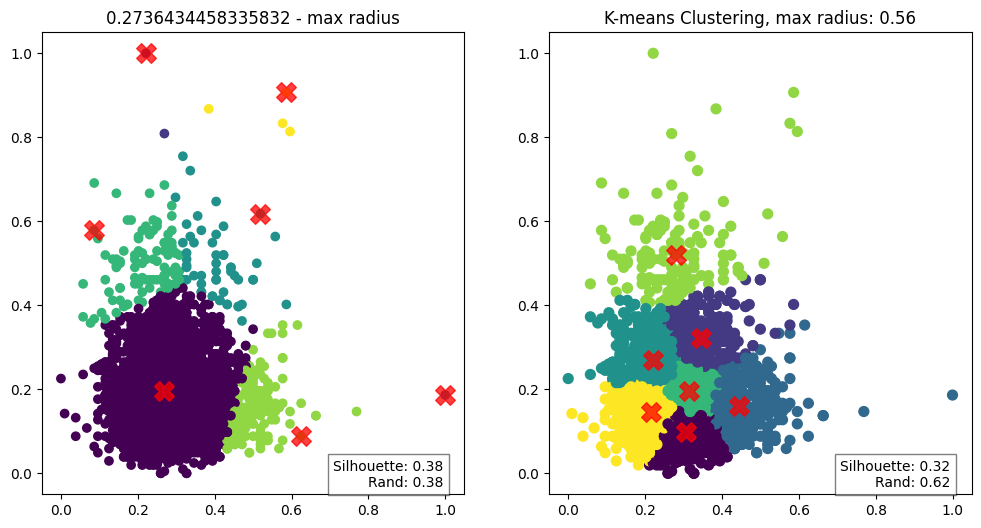

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, rand_score

# Configurar o tamanho da figura
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
df = pd.read_csv(f'reais/1/winequality-white.csv', sep=';')
df = df.rename(columns={'quality': 'label'})
for column in df.columns:
    if column != 'label':
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
df = df[['fixed acidity', 'volatile acidity', 'label']]
# Parte : Algoritmo greedy_k_means
n = len(df['label'].unique())
centers, max_r, predict = greedy_k_means(df, n, 2)
print(centers)
ss = silhouette_score(df.iloc[:,:-1], predict)
rs = rand_score(df['label'], predict)

# Plotar o resultado do greedy_k_means

# Plotar o resultado do greedy_k_means
ax[0].scatter(df.iloc[:,0], df.iloc[:,1], c=predict)
ax[0].scatter([c[0] for c in centers], [c[1] for c in centers], c='red', s=200, alpha=0.75, marker='X')
ax[0].set_title(f'{max_r} - max radius')
ax[0].text(0.95, 0.01, f'Silhouette: {ss:.2f}\nRand: {rs:.2f}',
           verticalalignment='bottom', horizontalalignment='right',
           transform=ax[0].transAxes, color='black', fontsize=10,
           bbox=dict(facecolor='white', alpha=0.5))

# Parte 2: K-means do sklearn
X, y = df.iloc[:, :-1], df['label']
kmeans = KMeans(n_clusters=len(y.unique()), random_state=42)
labels = kmeans.fit_predict(X)
mar_r_sklearn = max([dista(j,kmeans.cluster_centers_[labels[i]],2) for i,j in enumerate(X.values)])

# Imprimir métricas
sil_score = silhouette_score(X.values, labels)
rand_score_value = rand_score(y, labels)

# Plotar o resultado do K-means
ax[1].scatter(X.values[:, 0], X.values[:, 1], c=labels, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
ax[1].scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
ax[1].text(0.95, 0.01, f'Silhouette: {sil_score:.2f}\nRand: {rand_score_value:.2f}',
           verticalalignment='bottom', horizontalalignment='right',
           transform=ax[1].transAxes, color='black', fontsize=10,
           bbox=dict(facecolor='white', alpha=0.5))
# Configurar título e rótulos
ax[1].set_title(f'K-means Clustering, max radius: {mar_r_sklearn:.2f}')

# Exibir os gráficos
plt.show()



# Gerando metricas

In [26]:
type=1

In [27]:
metrics = []
csv_files = [f'data_{i+1}.csv' for i in range(10)]
csv_files = ['reais/1/winequality-red.csv', 'reais/1/winequality-white.csv', 'reais/2/Dry_Bean_Dataset.csv', 'reais/3/ObesityDataSet_raw_and_data_sinthetic.csv','reais/4/Iris.csv']
for i,csv in enumerate(tqdm(csv_files)):
    if i < 2:
        df = pd.read_csv(f'{csv}', sep=';')
    else:
            df = pd.read_csv(f'{csv}')
    for column in df.columns[:-1]:
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
    columns = df.columns[:5].tolist() + [df.columns[-1]]
    df = df[columns]
    n = len(df['label'].unique())
    df = df
    radius = []
    times = []
    sillhouette_s = []
    rand_s = []
    for j in range(30):
        start = time.time()
        centers, max_r, predict = greedy_k_means(df, n,type)
        end = time.time()
        radius.append(max_r)
        times.append(end-start)
        sillhouette_s.append(silhouette_score(df.iloc[:,:-1], predict))
        rand_s.append(rand_score(df['label'], predict))
    
    mean_radius = np.mean(radius)
    mean_time = np.mean(times)
    mean_sillhouette_s = np.mean(sillhouette_s)
    mean_rand_s = np.mean(rand_s)
    
    std_radius = np.std(radius)
    std_sillhouette_s = np.std(sillhouette_s)
    std_rand_s = np.std(rand_s)
    
    metrics.append([mean_radius, std_radius, mean_time, mean_sillhouette_s, std_sillhouette_s, mean_rand_s, std_rand_s])

df_greedy = pd.DataFrame(metrics, columns=['mean_radius', 'std_radius', 'mean_time', 'mean_sillhouette_s', 'std_sillhouette_s', 'mean_rand_s', 'std_rand_s'])

100%|██████████| 5/5 [01:20<00:00, 16.09s/it]


In [28]:
df_greedy

,mean_radius,std_radius,mean_time,mean_sillhouette_s,std_sillhouette_s,mean_rand_s,std_rand_s
0,1.130135,0.052679,0.234514,0.244650,0.088007,0.471605,0.036785
1,0.939594,0.062421,0.741078,0.295189,0.083434,0.381021,0.042877
2,0.787705,0.055657,0.584736,0.349632,0.077983,0.735020,0.045420
3,1.291063,0.042804,0.354308,0.147152,0.028454,0.708857,0.044243
4,1.262606,0.123619,0.010153,0.475628,0.030093,0.877220,0.046080


In [29]:
df_greedy.to_csv(f'/home/bdlemos/Faculdade/Semestre_5/ALG2/reais/greedy_metrics_{type}.csv', index=False)
df_greedy.mean()

mean_radius           1.082221
std_radius            0.067436
mean_time             0.384958
mean_sillhouette_s    0.302450
std_sillhouette_s     0.061594
mean_rand_s           0.634744
std_rand_s            0.043081
dtype: float64

In [30]:
metrics = []
csv_files = [f'data_{i+1}.csv' for i in range(10)]
csv_files = ['reais/1/winequality-red.csv', 'reais/1/winequality-white.csv', 'reais/2/Dry_Bean_Dataset.csv', 'reais/3/ObesityDataSet_raw_and_data_sinthetic.csv','reais/4/Iris.csv']
for i,csv in enumerate(tqdm(csv_files)):
    if i < 2:
        df = pd.read_csv(f'{csv}', sep=';')
    else:
            df = pd.read_csv(f'{csv}')
    for column in df.columns[:-1]:
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
    columns = df.columns[:5].tolist()
    X, y = df[columns], df['label']

    n = len(df['label'].unique())
    radius = []
    times = []
    sillhouette_s = []
    rand_s = []
    for j in range(30):
        start = time.time()
        kmeans = KMeans(n_clusters=len(y.unique()), random_state=42)
        labels = kmeans.fit_predict(X)
        #distance = lambda x1, x2: ((x1[0] - x2[0])**2 + (x1[1] - x2[1])**2)**0.5
        distance = lambda x1, x2: np.linalg.norm(np.array(x1) - np.array(x2), type)
        mar_r_sklearn = max([distance(j,kmeans.cluster_centers_[labels[i]]) for i,j in enumerate(X.values)])
        end = time.time()
        radius.append(mar_r_sklearn)
        times.append(end-start)
        sillhouette_s.append(silhouette_score(X.values, labels))
        rand_s.append(rand_score(y, labels))
    
    mean_radius = np.mean(radius)
    mean_time = np.mean(times)
    mean_sillhouette_s = np.mean(sillhouette_s)
    mean_rand_s = np.mean(rand_s)
    
    std_radius = np.std(radius)
    std_sillhouette_s = np.std(sillhouette_s)
    std_rand_s = np.std(rand_s)
    
    metrics.append([mean_radius, std_radius, mean_time, mean_sillhouette_s, std_sillhouette_s, mean_rand_s, std_rand_s])

df_sklearn = pd.DataFrame(metrics, columns=['mean_radius', 'std_radius', 'mean_time', 'mean_sillhouette_s', 'std_sillhouette_s', 'mean_rand_s', 'std_rand_s'])
df_sklearn.to_csv(f'/home/bdlemos/Faculdade/Semestre_5/ALG2/reais/sklearn_metrics_{type}.csv', index=False)
df_sklearn

100%|██████████| 5/5 [00:37<00:00,  7.53s/it]


,mean_radius,std_radius,mean_time,mean_sillhouette_s,std_sillhouette_s,mean_rand_s,std_rand_s
0,1.465994,6.661338e-16,0.085838,0.269983,5.551115e-17,0.589248,1.110223e-16
1,1.714458,6.661338e-16,0.139558,0.218755,5.551115e-17,0.616556,1.110223e-16
2,1.054144,2.220446e-16,0.137570,0.425514,5.551115e-17,0.889433,0.000000e+00
3,1.455458,6.661338e-16,0.126524,0.289893,1.110223e-16,0.788475,2.220446e-16
4,0.957455,3.330669e-16,0.003942,0.520362,0.000000e+00,0.973960,2.220446e-16


In [32]:
df_sklearn.mean()

mean_radius           1.329502e+00
std_radius            5.107026e-16
mean_time             9.868631e-02
mean_sillhouette_s    3.449017e-01
std_sillhouette_s     5.551115e-17
mean_rand_s           7.715342e-01
std_rand_s            1.332268e-16
dtype: float64

<Axes: >

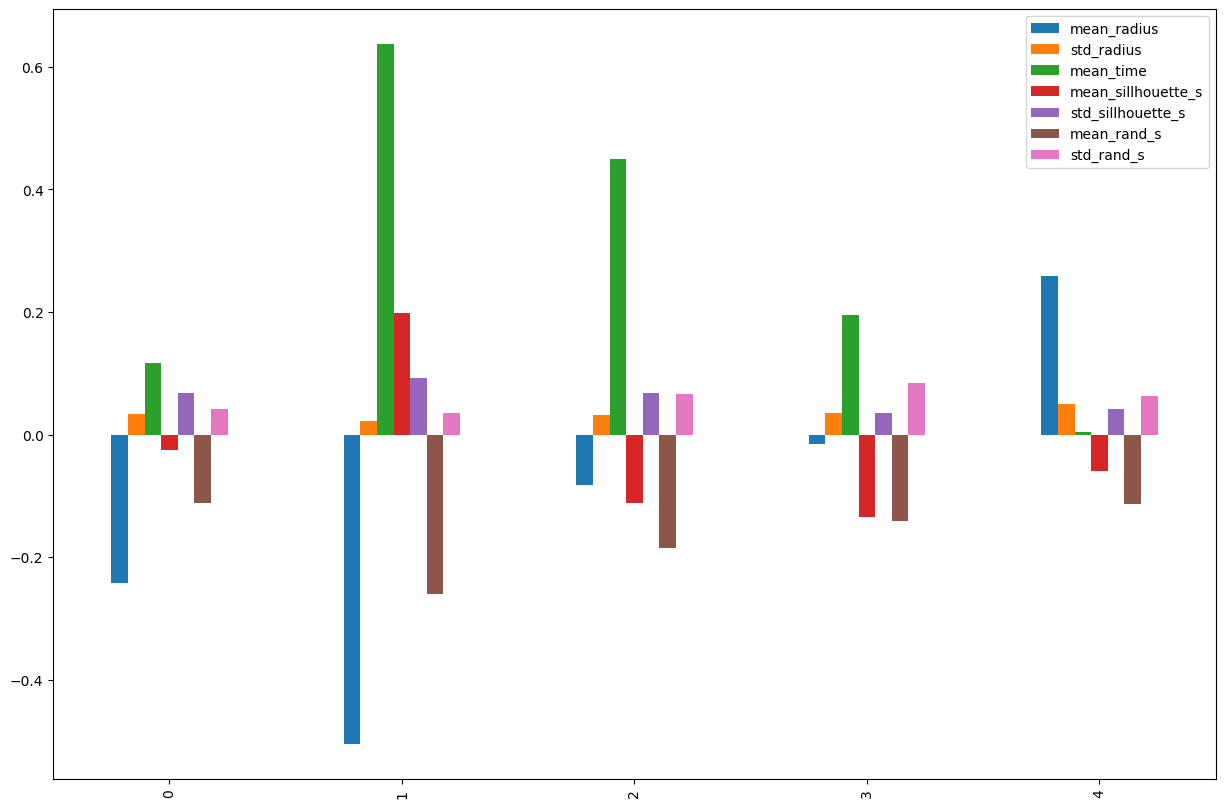

In [19]:
df_media = df_greedy-df_sklearn
df_media.plot(kind = 'bar',figsize=(15,10))

In [20]:
df_media = pd.DataFrame()
df_media['proporcao'] = df_greedy['mean_radius']/df_sklearn['mean_radius'].mean()
df_media['diferenca_sillhouette'] = df_greedy['mean_sillhouette_s'] - df_sklearn['mean_sillhouette_s']
df_media['diferenca_rand'] = df_greedy['mean_rand_s'] - df_sklearn['mean_rand_s']
df_media['diferenca_tempo'] = df_greedy['mean_time'] - df_sklearn['mean_time']
df_media.mean()

proporcao                0.842787
diferenca_sillhouette   -0.026110
diferenca_rand          -0.161793
diferenca_tempo          0.280477
dtype: float64

<Axes: title={'center': 'Densidade da proporção do raio greedy/sklearn'}, ylabel='Density'>

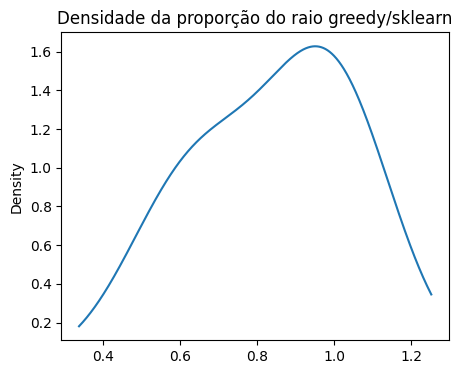

In [21]:
df_media['proporcao'].plot(kind = 'density',figsize=(5,4), title='Densidade da proporção do raio greedy/sklearn')

<Axes: ylabel='Density'>

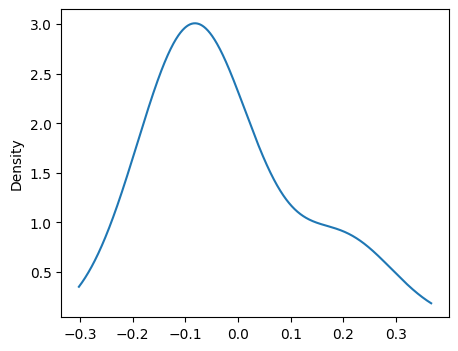

In [22]:
df_media['diferenca_sillhouette'].plot(kind = 'density',figsize=(5,4))